# **Insper - Projeto de Eletromagnetismo e Ondulatória - 2022.2** #

Jerônimo Afrange, Matheus Barros, Pedro Altobelli, Thiago Kawahara

## Etapa 1.1

### > Diagrama do modelo eletrodinâmico do circuito WPT

<img src="diagrama.jpeg" alt="Diagrama do circuito"/>

In [168]:
from math import *
from cmath import *
from numpy import linalg
import numpy as np
import matplotlib.pyplot as plt

### > Constantes

In [169]:
#indutâncias
l1=0.1375e-3
l2=l1
#resistências
r1=0.4577 * 4.5
r2=0.4594 * 4.5
rc=100
#frequência
f=60
#coeficiente de acoplamento
k=0.1
#capacitores
c1=0.1e-6
c2=c1
#fonte
uf=10

### > Cálculo da frequência de ressonância

In [170]:
# Frequencia de ressonancia
w_res = 1/sqrt(l1*c1)
frequencia_resonante = w_res/(2*pi)
print(f"Frequência de ressonância: {abs(frequencia_resonante)}")

Frequência de ressonância: 42920.89629716038


## Etapa 1.2

### > Código do modelo numérico

In [171]:
def CalcularTransformador(uf, rc, c1, w, l1, m, c2, l2):
    
    resultados = dict()
    
    xc1 = 1 / (w * c1 * 1j)
    xl1 = w * l1 * 1j
    
    xm = m * w * 1j
    
    xc2 = 1 / (w * c2 * 1j)
    xl2 = w * l2 * 1j
    zeq = (rc * xc2) / (rc + xc2)
    
    Z=np.array([[r1 + xc1 + xl1, -xm],[-xm, xl2 + r2 + zeq]])
    V=np.array([uf,0])
    I=np.dot(linalg.inv(Z),V)
    
    resultados['corrente-primaria'] = I[0]
    resultados['corrente-secundaria'] = I[1]
    resultados['tensao-carga'] = zeq * I[1]
    resultados['corrente-carga'] = resultados['tensao-carga'] / rc
    resultados['potencia-entrada'] = uf * I[0].conjugate()
    resultados['potencia-saida'] = resultados['tensao-carga'] * resultados['corrente-carga'].conjugate()
    resultados['eficiencia'] = resultados["potencia-saida"] / resultados["potencia-entrada"]
    
    return resultados

## Cálculo para os gráficos

In [172]:
# Indutancia mutua considerando k
m = k*sqrt(l1*l2)

correntes_primaria = []
correntes_secundaria = []
potencias_entrada = []
potencias_saida = []
eficiencias = []

freq = np.linspace(1, 100000, 2000)

i1max=0
fi1max=0

i2max=0
fi2max=0

emax=0
femax=0

for f in freq:
    w = 2 * pi * f
    resultados = CalcularTransformador(uf, rc, c1, w, l1, m, c2, l2)
    correntes_primaria.append(resultados['corrente-primaria'])
    correntes_secundaria.append(resultados['corrente-secundaria'])
    potencias_entrada.append(resultados['potencia-entrada'].real)
    potencias_saida.append(resultados['potencia-saida'].real)
    eficiencias.append(resultados['eficiencia'].real)
    
    if resultados['corrente-primaria'] > i1max:
        i1max = resultados['corrente-primaria']
        fi1max = f
        
    if resultados['corrente-secundaria'] > i2max:
        i2max = resultados['corrente-secundaria']
        fi2max = f
        
    if resultados['eficiencia'].real > emax:
        emax = resultados['eficiencia'].real
        femax = f

## Etapa 1.3

Corrente máxima na primária: 3.396 A a 43072.1 Hz
Corrente máxima na secundária: 0.707 A a 44422.8 Hz
Frequência de ressonância da etapa 1.1: 42920.9 Hz


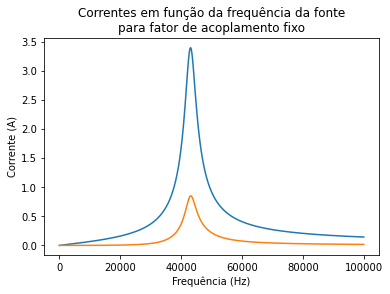

In [173]:
print('Corrente máxima na primária: %.3f A a %.1f Hz' % (round(abs(i1max), 3), round(fi1max, 1)))
print('Corrente máxima na secundária: %.3f A a %.1f Hz' % (round(abs(i2max), 3), round(fi2max, 1)))
print(f"Frequência de ressonância da etapa 1.1: {round(abs(frequencia_resonante), 1)} Hz")
        
plt.plot(freq, np.abs(correntes_primaria))
plt.plot(freq, np.abs(correntes_secundaria))
plt.xlabel('Frequência (Hz)')
plt.ylabel('Corrente (A)')
plt.title('Correntes em função da frequência da fonte\npara fator de acoplamento fixo')
plt.show()

In [174]:
correntes_primaria_k = []
correntes_secundaria_k = []
tensoes_carga_k = []

ks = np.linspace(0, 1, 1000)
w = frequencia_resonante * 2 * pi

for k in ks:
    m = k * sqrt(l1 * l2)
    resultados = CalcularTransformador(uf, rc, c1, w, l1, m, c2, l2)
    correntes_primaria_k.append(resultados['corrente-primaria'])
    correntes_secundaria_k.append(resultados['corrente-secundaria'])
    tensoes_carga_k.append(abs(resultados['tensao-carga']))

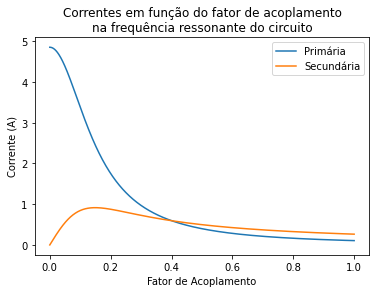

In [175]:
plt.plot(ks, np.abs(correntes_primaria_k))
plt.plot(ks, np.abs(correntes_secundaria_k))
plt.xlabel('Fator de Acoplamento')
plt.ylabel('Corrente (A)')
plt.legend(['Primária', 'Secundária'])
plt.title('Correntes em função do fator de acoplamento\nna frequência ressonante do circuito')
plt.show()

## Etapa 1.4

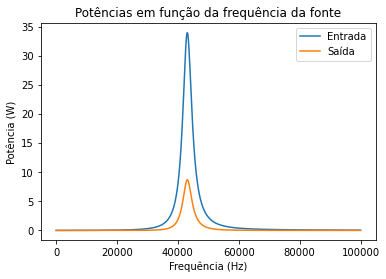

In [176]:
plt.plot(freq, potencias_entrada)
plt.plot(freq, potencias_saida)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Potência (W)')
plt.legend(['Entrada', 'Saída'])
plt.title('Potências em função da frequência da fonte')
plt.show()

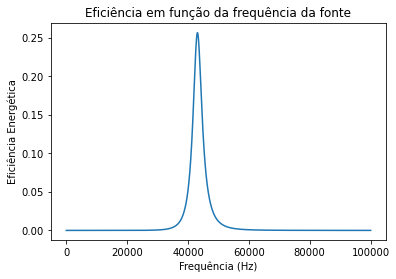

In [177]:
plt.plot(freq, eficiencias)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Eficiência Energética')
plt.title('Eficiência em função da frequência da fonte')
plt.show()

## Etapa 1.5

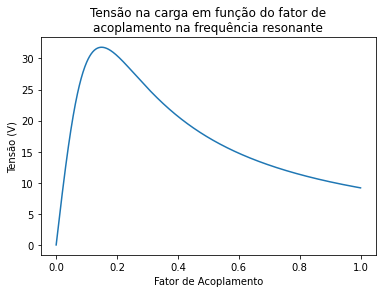

In [178]:
plt.plot(ks, tensoes_carga_k)
plt.xlabel('Fator de Acoplamento')
plt.ylabel('Tensão (V)')
plt.title('Tensão na carga em função do fator de\nacoplamento na frequência resonante')
plt.show()